## Align LLaVA-Next on RLAIF-V dataset

### Defining Variables

In [ ]:
MODEL_ID = "llava-hf/llava-v1.6-mistral-7b-hf"
REPO_ID = 'Venky0404/llava-v1.6-version2-mod-prompt'
WANDB_PROJECT = "llava-v1.6-ORPO-version2"
MAX_LENGTH = 1024

### Installations and Imports

In [ ]:
!pip install -q -U git+https://github.com/huggingface/transformers.git datasets gradio accelerate bitsandbytes peft
!pip install git+https://github.com/huggingface/trl.git -q
!pip install ninja packaging wandb -q
!MAX_JOBS=6 pip install flash-attn --no-build-isolation --upgrade -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import ORPOConfig, ORPOTrainer
import multiprocessing

### Load dataset

In [ ]:
import torch
from datasets import load_dataset, DatasetDict

In [ ]:
try:
    # Try to load the dataset normally
    ds = load_dataset('openbmb/RLAIF-V-Dataset', split="train[:5%]")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Load the dataset again with verifications ignored
    ds = load_dataset('openbmb/RLAIF-V-Dataset', verification_mode='no_checks')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds

Dataset({
    features: ['ds_name', 'image', 'question', 'chosen', 'rejected', 'origin_dataset', 'origin_split', 'idx', 'image_path'],
    num_rows: 4157
})

### Verify Dataset Size Print the number of records in the train split to compare with the expected count.

In [ ]:
# Print the number of records
print(f"Number of samples in the dataset: {len(ds)}")

Number of samples in the dataset: 4157


### Remove unnecessary columns after verifying the dataset

In [ ]:
# Columns to remove
cols_remove = ["ds_name", "origin_dataset", "origin_split", "idx", "image_path"]

# Remove the columns
ds = ds.remove_columns(cols_remove)

In [ ]:
ds

Dataset({
    features: ['image', 'question', 'chosen', 'rejected'],
    num_rows: 4157
})

In [ ]:
train_test_split_datasets = ds.train_test_split(test_size=0.15)
train_test_split_datasets["train"]

Dataset({
    features: ['image', 'question', 'chosen', 'rejected'],
    num_rows: 3533
})

In [ ]:
train_test_split_datasets["test"]

Dataset({
    features: ['image', 'question', 'chosen', 'rejected'],
    num_rows: 624
})

In [ ]:
train_set_before_collate = train_test_split_datasets["train"]
validation_set_before_collate = train_test_split_datasets["test"]

### Define collate functions

In [ ]:
from datasets import Dataset

def collate_fn(batch):
    # Initialize lists to hold data
    images= []
    prompts = []
    chosen_responses = []
    rejected_responses = []

    # Process each entry in the batch
    for entry in batch:
      image = entry["image"]  # Get the image (used directly in the prompt)
      question = entry["question"]  # Get the question
      chosen = entry["chosen"]  # Get the chosen response
      rejected = entry["rejected"]  # Get the rejected response

      # Construct the prompt in the model's expected format using a raw string

      prompt = f"[INST] <image>\nProvide answer to the following question that best aligns with human preferences.{question} [/INST]{chosen}"

      # Append to respective lists
      images.append(image)
      prompts.append(prompt)
      chosen_responses.append(chosen)
      rejected_responses.append(rejected)

    # Use Dataset.from_dict() from the 'datasets' library
    orpo_dataset = Dataset.from_dict({
        "images":images,
        "prompt": prompts,
        "chosen": chosen_responses,
        "rejected": rejected_responses,
    })

    # Print dataset structure in the requested format
    print(f"Dataset({{\n    features: {orpo_dataset.column_names}, \n    num_rows: {orpo_dataset.num_rows} \n}})")

    return orpo_dataset


In [ ]:
train_set_before_collate, validation_set_before_collate

(Dataset({
     features: ['image', 'question', 'chosen', 'rejected'],
     num_rows: 3533
 }),
 Dataset({
     features: ['image', 'question', 'chosen', 'rejected'],
     num_rows: 624
 }))

In [ ]:
train_set_after_collate = collate_fn(train_set_before_collate)

Dataset({
    features: ['images', 'prompt', 'chosen', 'rejected'], 
    num_rows: 3533 
})


In [ ]:
validation_set_after_collate = collate_fn(validation_set_before_collate)

Dataset({
    features: ['images', 'prompt', 'chosen', 'rejected'], 
    num_rows: 624 
})


In [ ]:
train_set_after_collate[0]

{'images': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=336x381>,
 'prompt': "[INST] <image>\nProvide answer to the following question that best aligns with human preferences.Explain the elements of the image with thorough attention to detail. [/INST]In the center of this image, a small puppy with brown and white fur is the main subject. The puppy's eyes, full of curiosity, are looking directly at the camera, making it appear as if it's engaging in a playful conversation. Its ears, perked up and alert, add to its endearing demeanor. \n\nThe puppy is comfortably seated on a beige tile floor, which contrasts with its own fur color. A wooden chair leg can be seen nearby, suggesting that the setting might be a living room or a similar indoor space.\n\nAdding a touch of realism to this intimate scene, there's a plastic bag from Whole Foods casually placed in the background. This detail suggests that perhaps someone was shopping and brought home their groceries while the puppy was 

In [ ]:
validation_set_after_collate[0]

{'images': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=829x328>,
 'prompt': '[INST] <image>\nProvide answer to the following question that best aligns with human preferences.Create a detailed description describing the contents of the given art image. Include the objects, colors, art style, art genre, etc. [/INST]The image shows a group of three people, who appear to be Russian soldiers, climbing up a snow-covered mountain during a winter landscape. The majority of the frame is filled with a blue and gray color palette, likely imitating the cool tones of winter. The art style seems to lean towards Impressionism, especially considering the emphasis on light and color in depicting the scene. This piece can be categorized as a historical genre painting due to its representation of a past event and the inclusion of recognizable military elements.',
 'chosen': 'The image shows a group of three people, who appear to be Russian soldiers, climbing up a snow-covered mountain during a

## Load Processor

Next, we'll load the processor which is used to prepare the data in the format that the model expects. Neural networks like LLaVa don't directly take images and text as input, but rather pixel_values (which is a resized, rescaled, normalized and optionally splitted version of the receipt images), input_ids (which are text token indices in the vocabulary of the model), etc. This is handled by the processor.

In [ ]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained(MODEL_ID)
processor.tokenizer.padding_side = "right" # during training, one always uses padding on the right

preprocessor_config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

## Load Model

###Finetuning - Full/LoRa/Q-LoRa

In [ ]:
from transformers import BitsAndBytesConfig, LlavaNextForConditionalGeneration
import torch

USE_LORA = False
USE_QLORA = True

## Load model

# Three options for training, from the lowest precision training to the highest precision training:
# - QLora
# - Standard Lora
# - Full fine-tuning
if USE_QLORA or USE_LORA:
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
        )
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        quantization_config=bnb_config,
    )
else:
    # for full fine-tuning, we can speed up the model using Flash Attention
    # only available on certain devices, see https://github.com/Dao-AILab/flash-attention?tab=readme-ov-file#installation-and-features
    model = LlavaNextForConditionalGeneration.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16,
        _attn_implementation="flash_attention_2",
    )

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Apply PEFT
After loading the base model, we're going to add LoRa adapter layers. We're going to only train these adapter layers (the base model is kept frozen).

The difference here with other models are the layers at which we're going to add adapters (in PEFT this is called target_modules). This typically depends a bit on the model.

Here, I based myself off the original find_all_linear_names function found in the original LLaVa repository.

* Language model part: It makes sense to add adapters to the language model part, as this is where the primary text generation and response alignment occurs. We are working with human preferences in text (chosen vs. rejected), so the language model needs to be fine-tuned to prioritize preferred responses.

* Vision model: Since our dataset includes images (and your task involves aligning preferences related to image-text interactions), it could also be beneficial to add adapters to the vision model part. This ensures the vision component also gets fine-tuned for better understanding of images in a way that aligns with your preferences.

* Multimodal projector: Given that our task involves both images and text, the multimodal projector (which merges image and text representations) plays a key role. Adding adapters here would help improve how the model combines visual and textual information in alignment with the preferred responses.

Hence, in our use case, adding adapters to the vision encoder, multimodal projector, and the language model part would likely yield better results.

In [ ]:
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model


def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    #multimodal_keywords = ['multi_modal_projector', 'vision_model']

    # We are making sure we add LoRA layers to vision as well as text layers
    # as we are processing both of them in our alignment
    multimodal_keywords = []

    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in multimodal_keywords):
            continue
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

    if 'lm_head' in lora_module_names: # needed for 16-bit
        lora_module_names.remove('lm_head')
    return list(lora_module_names)


lora_config = LoraConfig(
    r=8,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=find_all_linear_names(model),
    init_lora_weights="gaussian",
)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 24,616,960 || all params: 7,591,364,608 || trainable%: 0.3243


In [ ]:
next(model.parameters()).device

device(type='cuda', index=0)

In [ ]:
print(f"Model Architecture: {model}")

Model Architecture: PeftModel(
  (base_model): LoraModel(
    (model): LlavaNextForConditionalGeneration(
      (vision_tower): CLIPVisionModel(
        (vision_model): CLIPVisionTransformer(
          (embeddings): CLIPVisionEmbeddings(
            (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
            (position_embedding): Embedding(577, 1024)
          )
          (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (encoder): CLIPEncoder(
            (layers): ModuleList(
              (0-23): 24 x CLIPEncoderLayer(
                (self_attn): CLIPSdpaAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=1024, out_features=1024, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in

## Training

Omit the following steps if you want to just do the inference task.

### Setting up ORPO Trainer

In [ ]:
cfg = ORPOConfig(
    output_dir='content/llava-v1.6-mistral-7b-ORPO',     # usual HF Trainer args: https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer.args
    num_train_epochs=3,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_accumulation_steps=4,          # number of steps before performing a backward/update pass
    gradient_checkpointing=True,            # use gradient checkpointing to save memory
    optim="adamw_hf",
    logging_steps=20,                       # log every 20 steps
    bf16=True,                              # use bfloat16 precision
    tf32=True,                              # use tf32
    learning_rate=2e-5,                     # learning rate
    warmup_steps=20,
    lr_scheduler_type="cosine",
    remove_unused_columns=False,
    beta=0.1,                               # ORPO beta
    weight_decay=1e-5,
    adam_beta2=0.999,
    eval_strategy="steps",
    eval_steps=40,
    save_total_limit=3,                     # args related to saving the model...
    save_steps=50,
    save_strategy="steps",
    push_to_hub=True,
    report_to=['wandb'],                    # report metrics to Weights & Biases
    hub_model_id=REPO_ID,
)

In [ ]:
import wandb
run = wandb.init(project=WANDB_PROJECT)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: venkateshalla04 (venkateshalla04-deggendorf-institute-of-technology). Use `wandb login --relogin` to force relogin


In [ ]:
orpo_trainer = ORPOTrainer(
    model=model,
    args=cfg,
    train_dataset=train_set_after_collate,
    eval_dataset=validation_set_after_collate,
    processing_class = processor.tokenizer
)

/usr/local/lib/python3.10/dist-packages/trl/trainer/orpo_trainer.py:236: UserWarning: `max_length` is not set in the ORPOConfig's init it will default to `512` by default, but you should do it yourself in the future.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/orpo_trainer.py:245: UserWarning: `max_prompt_length` is not set in the ORPOConfig's init it will default to `128` by default, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/3533 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

Map:   0%|          | 0/624 [00:00<?, ? examples/s]

In [ ]:
# Evaluate the model on the evaluation dataset before training to undestand the baseline
initial_eval_metrics = orpo_trainer.evaluate()
print("Initial Evaluation Metrics:", initial_eval_metrics)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Initial Evaluation Metrics: {'eval_loss': 1.9551974534988403, 'eval_model_preparation_time': 0.0149, 'eval_runtime': 69.8926, 'eval_samples_per_second': 8.928, 'eval_steps_per_second': 1.116, 'eval_rewards/chosen': -0.05503428727388382, 'eval_rewards/rejected': -0.19035376608371735, 'eval_rewards/accuracies': 0.9983974099159241, 'eval_rewards/margins': 0.13531948626041412, 'eval_logps/rejected': -1.903537631034851, 'eval_logps/chosen': -0.550342857837677, 'eval_logits/rejected': -2.7083942890167236, 'eval_logits/chosen': -2.710167407989502, 'eval_nll_loss': 1.9418408870697021, 'eval_log_odds_ratio': -0.1335659772157669, 'eval_log_odds_chosen': 2.1804652214050293}


In [ ]:
orpo_trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss,Validation Loss,Model Preparation Time,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
40,3.211400,0.725849,0.014900,68.783600,9.072000,1.134000,-0.005456,-0.160600,1.000000,0.155145,-1.606001,-0.054556,-2.158293,-2.223219,0.724151,-0.016985,5.499539
80,2.724200,0.652238,0.014900,68.800900,9.070000,1.134000,-0.004046,-0.167801,1.000000,0.163755,-1.678014,-0.040459,-2.274570,-2.369094,0.650973,-0.012649,6.655137
120,2.567300,0.637203,0.014900,68.792400,9.071000,1.134000,-0.004161,-0.165025,1.000000,0.160864,-1.650250,-0.041608,-2.290957,-2.373692,0.635849,-0.013542,6.375476
160,2.506800,0.626903,0.014900,68.786700,9.072000,1.134000,-0.003778,-0.166472,1.000000,0.162694,-1.664720,-0.037777,-2.373939,-2.428793,0.625573,-0.013303,6.710630
200,2.471000,0.619023,0.014900,68.805700,9.069000,1.134000,-0.003280,-0.170443,1.000000,0.167163,-1.704426,-0.032799,-2.419725,-2.465775,0.617812,-0.012116,6.976161
240,2.179200,0.621052,0.014900,68.789300,9.071000,1.134000,-0.003277,-0.181558,1.000000,0.178281,-1.815579,-0.032772,-2.367760,-2.406573,0.619904,-0.011483,7.576509


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-pac

KeyboardInterrupt: 

In [ ]:
final_metrics = orpo_trainer.evaluate()
print(final_metrics)

Step,Training Loss,Validation Loss,Model Preparation Time,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
40,3.211400,0.725849,0.014900,68.783600,9.072000,1.134000,-0.005456,-0.160600,1.000000,0.155145,-1.606001,-0.054556,-2.158293,-2.223219,0.724151,-0.016985,5.499539
80,2.724200,0.652238,0.014900,68.800900,9.070000,1.134000,-0.004046,-0.167801,1.000000,0.163755,-1.678014,-0.040459,-2.274570,-2.369094,0.650973,-0.012649,6.655137
120,2.567300,0.637203,0.014900,68.792400,9.071000,1.134000,-0.004161,-0.165025,1.000000,0.160864,-1.650250,-0.041608,-2.290957,-2.373692,0.635849,-0.013542,6.375476
160,2.506800,0.626903,0.014900,68.786700,9.072000,1.134000,-0.003778,-0.166472,1.000000,0.162694,-1.664720,-0.037777,-2.373939,-2.428793,0.625573,-0.013303,6.710630
200,2.471000,0.619023,0.014900,68.805700,9.069000,1.134000,-0.003280,-0.170443,1.000000,0.167163,-1.704426,-0.032799,-2.419725,-2.465775,0.617812,-0.012116,6.976161
240,2.179200,0.621052,0.014900,68.789300,9.071000,1.134000,-0.003277,-0.181558,1.000000,0.178281,-1.815579,-0.032772,-2.367760,-2.406573,0.619904,-0.011483,7.576509
259,2.179200,0.618612,0.014900,68.837800,9.065000,1.133000,-0.002779,-0.180606,1.000000,0.177827,-1.806061,-0.027794,-2.436242,-2.474863,0.617525,-0.010871,7.438167


{'eval_loss': 0.6186122298240662, 'eval_model_preparation_time': 0.0149, 'eval_runtime': 68.8378, 'eval_samples_per_second': 9.065, 'eval_steps_per_second': 1.133, 'eval_rewards/chosen': -0.002779419766739011, 'eval_rewards/rejected': -0.18060606718063354, 'eval_rewards/accuracies': 1.0, 'eval_rewards/margins': 0.1778266429901123, 'eval_logps/rejected': -1.806060552597046, 'eval_logps/chosen': -0.027794193476438522, 'eval_logits/rejected': -2.4362423419952393, 'eval_logits/chosen': -2.474862575531006, 'eval_nll_loss': 0.617525041103363, 'eval_log_odds_ratio': -0.010871303267776966, 'eval_log_odds_chosen': 7.438166618347168}


You can see that training a model that has decreasing training and validation loss is successful. However, I had to stop here due to compute issues.

## Inference

Let's see if the model has learned something. We'll load the model from the hub first. Notice that, as we only trained adapters on top of the base model, the [repository on the hub](https://huggingface.co/Venky0404/llava-v1.6-version2-mod-prompt) to which we pushed only contains the weights and configuration of the adapters. This is a very lightweight file smaller than 100 MB.

Thanks to the PEFT integration in Transformers, the `from_pretrained` method will automatically load the weights of the base model as well as the adapter weights.

To reduce inference costs, we'll again load the model in 4 bits by passing a `quantization_config`, in order to reduce memory usage.

In [ ]:
from transformers import AutoProcessor, BitsAndBytesConfig, LlavaNextForConditionalGeneration
import torch

processor = AutoProcessor.from_pretrained(MODEL_ID)

# Define quantization config
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.float16
)
# Load the base model with adapters on top
model = LlavaNextForConditionalGeneration.from_pretrained(
    REPO_ID,
    torch_dtype=torch.float16,
    quantization_config=quantization_config,
)

`low_cpu_mem_usage` was None, now default to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

### Select and Visualize a random sample

In [ ]:
import random

random_sample = random.randint(0,len(validation_set_before_collate))
test_example = validation_set_before_collate[random_sample]
test_image = test_example["image"]
test_question = test_example["question"]
test_chosen = test_example["chosen"]
test_rejected = test_example["rejected"]
test_question, test_chosen, test_rejected

("Look at the image and describe the celebrity's facial expressions, clothing, and any distinctive features.",
 'The celebrity has a smiling face, wears black gloves and a black leather jacket with buttons.',
 'The woman has a smiling face, long brown hair, and is wearing a black coat and gloves.')

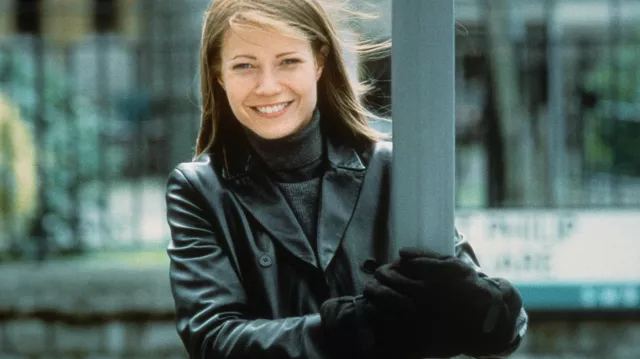

In [ ]:
test_image

Next we need to prepare the image for the model, along with the text prompt we used during training. We need to apply the chat template to make sure the format is respected.

Notice that this is exactly the same as what we did for the evaluation data collate function.

### Preparing the image for the model along with text prompt

In [ ]:
# prepare image and prompt for the model
# TODO this can be replaced by apply_chat_template when the processor supports this
prompt = f"[INST] <image>\n Provide answer to the following question that best aligns with human preferences.{test_question} [/INST]"
inputs = processor(text=prompt, images=[test_image], return_tensors="pt").to("cuda")
for k,v in inputs.items():
    print(k,v.shape)

input_ids torch.Size([1, 48])
attention_mask torch.Size([1, 48])
pixel_values torch.Size([1, 5, 3, 336, 336])
image_sizes torch.Size([1, 2])


Next we let the model autoregressively generate tokens using the [generate()](https://huggingface.co/docs/transformers/v4.40.1/en/main_classes/text_generation#transformers.GenerationMixin.generate) method, which is recommended for use at inference time. This method feeds each predicted token back into the model as conditioning for each next time step.

Do note that there are various ways of decoding text, here we use greedy decoding which is the default. There are various fancier methods such as beam search and top-k sampling. Refer to [this amazing blog post](https://huggingface.co/blog/how-to-generate) for all details.

### Model output generation

In [ ]:
# Generate token IDs
generated_ids = model.generate(**inputs,max_length=MAX_LENGTH)

# Decode back into text
generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

# Only give us the answer and not repeat prompt and question
generated_texts = generated_texts[0].split("[/INST]", 1)[1].strip()


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [ ]:
generated_texts

'The celebrity, a woman, is smiling and appears to be in a good mood. She is wearing a black leather jacket and has long blonde hair. She is also holding onto a pole with her hands.'

## Using Gradio to host the model

In [ ]:
import gradio as gr

# Function to handle inference
def answer_question(image, question):
    # Prepare the prompt
    prompt = f"[INST] <image>\n Provide answer to the following question that best aligns with human preferences. {question} [/INST]"

    # Process inputs
    inputs = processor(text=prompt, images=[image], return_tensors="pt").to("cuda")

    # Generate the answer
    generated_ids = model.generate(**inputs, max_length=128)

    # Decode the answer
    generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)

    # Remove the parts before and including [/INST]
    generated_texts = generated_texts[0].split("[/INST]", 1)[1].strip()

    return generated_texts

In [ ]:
# Gradio interface
iface = gr.Interface(
    fn=answer_question,
    inputs=[gr.Image(type="pil"), gr.Textbox(lines=2, placeholder="Enter your question")],
    outputs="text",
    title="LLava Model Demo",
    description="Ask a question about an image!"
)

In [ ]:
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://3102b6bea1625ad451.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
iface.close()

Closing server running on port: 7861
